# PARAMETRAGE

In [10]:
%pip install dill imblearn pendulum ucimlrepo yellowbrick loguru

Note: you may need to restart the kernel to use updated packages.


In [11]:
import os
from pathlib import Path

import dill
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import pendulum
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
from imblearn.pipeline import Pipeline as imb_Pipeline
from loguru import logger
from sklearn import set_config
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix,
                             classification_report,
                             ConfusionMatrixDisplay,
                             roc_auc_score,
                             accuracy_score,
                             precision_score,
                             recall_score,
                             f1_score,
                             RocCurveDisplay,
                             PrecisionRecallDisplay,
                            )
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, OneHotEncoder
from ucimlrepo import fetch_ucirepo, list_available_datasets
from yellowbrick.classifier import DiscriminationThreshold

set_config(display='diagram')
pd.set_option("display.max_columns", None)


In [12]:
def afficher_dataframes(dfs, head_n=5):
    """
    Affiche les informations d'un DataFrame ou d'un dictionnaire de DataFrames.

    Paramètres :
    - dfs : un DataFrame ou un dictionnaire {nom: DataFrame}
    - head_n : nombre de lignes à afficher avec head()
    """

    if isinstance(dfs, pd.DataFrame):
        # Cas d’un seul DataFrame
        print(f"\n📄 DESCRIPTION")
        print(f"📐 Taille : {dfs.shape[0]} lignes × {dfs.shape[1]} colonnes")
        print(f"🧠 Colonnes : {dfs.columns.tolist()}")
        display(dfs.head(head_n))

    elif isinstance(dfs, dict):
        if not dfs:
            print("⚠️ Dictionnaire vide.")
            return

        for name, df in dfs.items():
            if isinstance(df, pd.DataFrame):
                print(f"\n📄 Nom : {name}")
                print(f"📐 Taille : {df.shape[0]} lignes × {df.shape[1]} colonnes")
                print(f"🧠 Colonnes : {df.columns.tolist()}")
                display(df.head(head_n))
            else:
                print(f"⚠️ L’objet '{name}' n’est pas un DataFrame.")

    else:
        print("❌ Entrée non valide : fournir un DataFrame ou un dictionnaire de DataFrames.")


In [13]:
train_df=pd.read_csv("../data/cleaned data/train_df.csv")

# MODELISATION

## Data preparation

In [14]:
afficher_dataframes(train_df)


📄 DESCRIPTION
📐 Taille : 165034 lignes × 14 colonnes
🧠 Colonnes : ['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [15]:
train_df.drop(['id',
           'CustomerId',
           "Surname"
       ], axis=1, inplace=True)
afficher_dataframes(train_df)


📄 DESCRIPTION
📐 Taille : 165034 lignes × 11 colonnes
🧠 Colonnes : ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


## Train / test split

In [81]:
x_values = train_df.drop(columns=['Exited'])  
y_target = train_df.Exited

In [82]:
x_train, x_test, y_train, y_test = train_test_split(x_values, y_target, test_size=0.2, random_state=42, stratify=y_target)

In [83]:
x_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
112149,726,France,Female,35.0,1,0.00,2,1.0,1.0,141466.85
70095,481,France,Female,37.0,8,152303.66,2,1.0,0.0,175082.20
29247,583,France,Female,35.0,5,0.00,1,0.0,0.0,102581.11
161355,644,France,Female,32.0,7,0.00,2,1.0,0.0,77965.67
105992,709,France,Male,29.0,5,128548.49,1,1.0,1.0,140941.47


In [84]:
y_train.value_counts(normalize=True).mul(100).round(2)

Exited
0    78.84
1    21.16
Name: proportion, dtype: float64

In [85]:
y_train.value_counts(normalize=True).mul(100).round(2)

Exited
0    78.84
1    21.16
Name: proportion, dtype: float64

### Feature engineering

In [86]:
x_values.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97
1,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50
2,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69
3,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88
4,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83


In [ ]:
# numerical
numeric_features = x_values.select_dtypes(include="number").columns
# categorical
onehot_features = ['Gender',"Geography"]

In [88]:
x_train.loc[:, numeric_features]

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
112149,726,35.0,1,0.00,2,1.0,1.0,141466.85
70095,481,37.0,8,152303.66,2,1.0,0.0,175082.20
29247,583,35.0,5,0.00,1,0.0,0.0,102581.11
161355,644,32.0,7,0.00,2,1.0,0.0,77965.67
105992,709,29.0,5,128548.49,1,1.0,1.0,140941.47
...,...,...,...,...,...,...,...,...
123771,752,52.0,2,131694.54,1,1.0,0.0,159920.93
22900,469,24.0,6,79858.13,1,1.0,1.0,131736.23
40851,526,52.0,1,0.00,2,0.0,0.0,111342.66
52537,683,34.0,9,0.00,1,1.0,0.0,38691.34


In [ ]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='undefined')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', onehot_transformer, onehot_features)
])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='undefined',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Gender']),
                                ('country',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='United-States',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['Geography'])])

## Modeling

#### Dummy regressor

In [ ]:
# Pipeline
dm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', DummyClassifier())
])

dm_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender']),
                                                 ('country',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='United-States',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Geography'])])),
                ('clf', DummyClassifier())])

In [ ]:
# Training
dm_pipeline.fit(x_train, y_train)

# Predictions & evaluation
dm_y_pred_test = dm_pipeline.predict(x_test)
dm_y_proba_test = dm_pipeline.predict_proba(x_test)[:, 1]

logger.info(f"AUC: {roc_auc_score(y_test, dm_y_proba_test):.2f}")
logger.info(f"Classification report: \n{classification_report(y_test, dm_y_pred_test)}")

2025-05-19 15:09:34.989 | INFO     | __main__:<module>:9 - AUC: 0.50
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

#### Logistic regression

In [ ]:
# Pipeline
rl_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])
rl_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Gender']),
                                                 ('country',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='United-States',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Geography'])])),
                ('clf', LogisticRegression(max_iter=1000))])

##### Baseline

In [ ]:
# 8. Entraînement
rl_pipeline.fit(x_train, y_train)

# 9. Prédictions & évaluation
rl_y_pred_test = rl_pipeline.predict(x_test)
rl_y_proba_test = rl_pipeline.predict_proba(x_test)[:, 1]

logger.info(f"AUC: {roc_auc_score(y_test, rl_y_proba_test):.2f} ")
logger.info(f"Classification report: \n{classification_report(y_test, rl_y_pred_test)}")

2025-05-19 15:09:35.948 | INFO     | __main__:<module>:9 - AUC: 0.81 
2025-05-19 15:09:36.021 | INFO     | __main__:<module>:11 - Classification report: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     26023
           1       0.69      0.38      0.49      6984

    accuracy                           0.83     33007
   macro avg       0.77      0.67      0.70     33007
weighted avg       0.82      0.83      0.81     33007



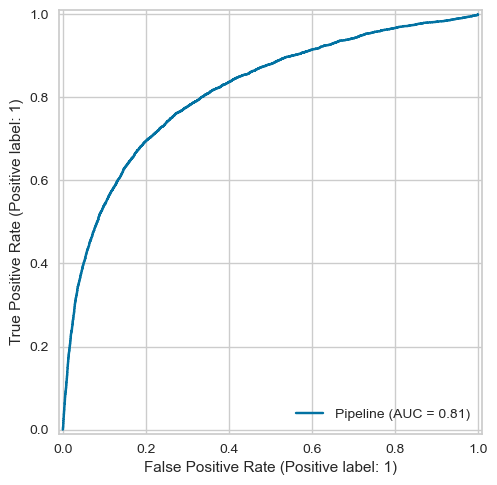

In [94]:
RocCurveDisplay.from_estimator(rl_pipeline, x_test, y_test);

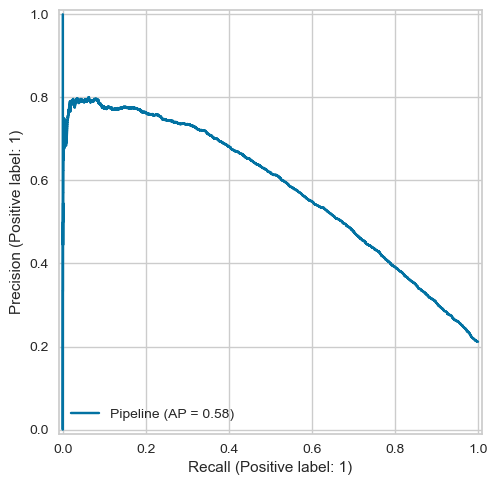

In [95]:
PrecisionRecallDisplay.from_estimator(rl_pipeline, x_test, y_test);


##### Tuning hyperparameters

In [96]:
rl_param_grid = {
    "clf__penalty": ["l2"],  # 'l1' si solver = 'liblinear' ou 'saga'
    "clf__C": [0.01, 0.1, 1, 2, 3, 5, 10],
    "clf__solver": ['liblinear', 'lbfgs', "sag", "saga"],  # lbfgs ne supporte que l2
    "clf__class_weight": ['balanced', None],
}

In [ ]:
# Cross-validation
cv = StratifiedKFold(n_splits=5) 
rl_grid_search = GridSearchCV(rl_pipeline, rl_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1)

# Training
rl_grid_search.fit(x_train, y_train)

# Best params
logger.info(f"Best params : {rl_grid_search.best_params_}")

# Evaluation
rl_y_pred_test_opt = rl_grid_search.predict(x_test)
rl_y_proba_test_opt  = rl_grid_search.predict_proba(x_test)[:, 1]

logger.info(f"AUC : {roc_auc_score(y_test, rl_y_proba_test_opt):.2f}")
logger.info(f"F1-score : {f1_score(y_test, rl_y_pred_test_opt):.2f}")
logger.info(f"Accuracy : {accuracy_score(y_test, rl_y_pred_test_opt):.2f}")


##### Discrimination threshold

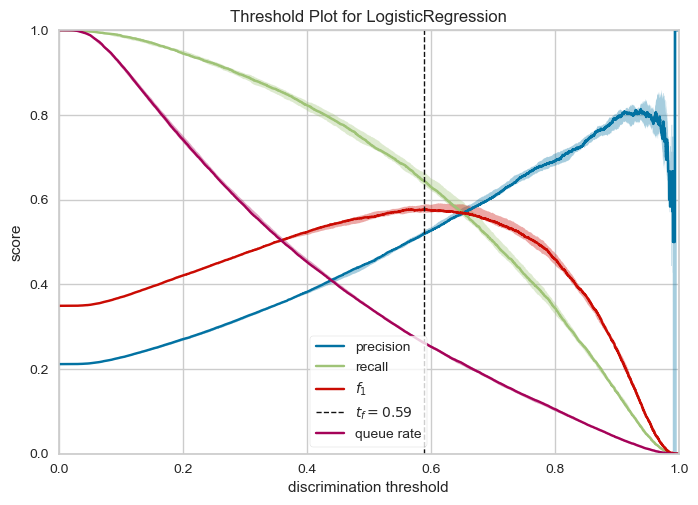

In [ ]:
viz = DiscriminationThreshold(rl_grid_search.best_estimator_, random_state=42, fbeta=1.0, cv=cv, argmax="fscore")

viz.fit(x_train, y_train)
viz.score(x_test, y_test)
viz.show();

##### Save model

In [ ]:
# Save model

#model_path_name = Path(MODEL_DIR, "best_logistic_model.dill")

#logger.info(f"Model path name: {model_path_name}")
#with open(model_path_name, "wb") as fp:
#    dill.dump(rl_grid_search.best_estimator_, fp)

NameError: name 'MODEL_DIR' is not defined

### KNN

#### Baseline

In [ ]:
# Pipeline
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', KNeighborsClassifier(n_neighbors=10))
])

knn_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hours_per_week', 'capital_diff'], dtype='object')),
                                                 ('ord',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='undefined',
                                                                                 strategy='constant')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(catego...
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'occupation',
                                                   'relationship', 'race',
                                                   'sex', 'marital_status']),
                                                 ('country',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='United-States',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['native_country'])])),
                ('clf', KNeighborsClassifier(n_neighbors=10))])

In [ ]:
# 8. Entraînement
knn_pipeline.fit(x_train, y_train)

# 9. Prédictions & évaluation
knn_y_pred_test = knn_pipeline.predict(x_test)
knn_y_proba_test = knn_pipeline.predict_proba(x_test)[:, 1]


logger.info(f"AUC: {roc_auc_score(y_test, knn_y_proba_test):.2f}")

logger.info(f"Classification report: \n{classification_report(y_test, knn_y_pred_test)}")

2025-04-17 18:32:42.095 | INFO     | __main__:<module>:9 - AUC: 0.88
2025-04-17 18:32:42.195 | INFO     | __main__:<module>:11 - Classification report: 
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      7416
           1       0.72      0.56      0.63      2336

    accuracy                           0.84      9752
   macro avg       0.80      0.75      0.77      9752
weighted avg       0.84      0.84      0.84      9752



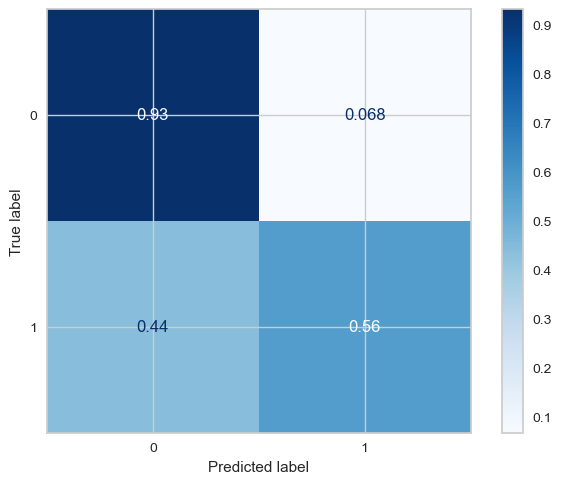

In [ ]:
class_names = np.unique(y_test)
ConfusionMatrixDisplay.from_estimator(knn_pipeline, x_test, y_test,
                                      display_labels=class_names,
                                      normalize="true", cmap=plt.cm.Blues);

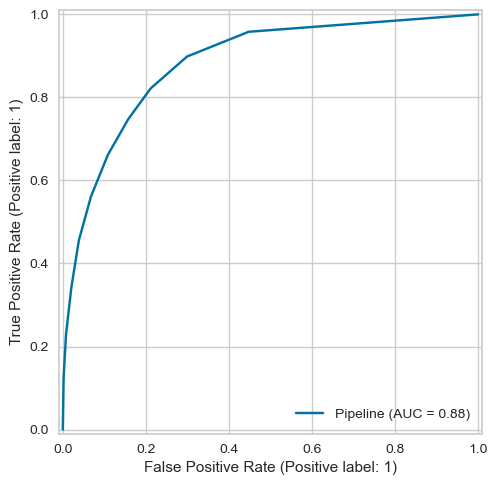

In [ ]:
RocCurveDisplay.from_estimator(knn_pipeline, x_test, y_test);

## Modeles Ensembliste

### Random forest

### Gradient Boosting

### XgBoost
